In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
print('input complete')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



Streaming output truncated to the last 5000 lines.
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person952_bacteria_2877.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1315_virus_2270.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1392_bacteria_3538.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person475_bacteria_2025.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1288_bacteria_3251.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person442_virus_900.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person755_bacteria_2659.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person655_bacteria_2547.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person126_virus_255.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/tra

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

# enable cuDNN autotuner
torch.backends.cudnn.benchmark = True

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type=="cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [4]:
base_dir ='/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE   = 256
BATCH_SIZE = 32
EPOCHS     = 50
timesteps  = 16


# noise schedule for your two-step forward_noise
time_bar = 1 - np.linspace(0,1.0, timesteps+1)


In [5]:
# after you define time_bar (numpy array of length T+1):
tb = torch.from_numpy(time_bar).float().to(device)      # [T+1]
betas = 1 - (tb[1:] / tb[:-1])                         # [0…T-1]
betas = betas.clamp(0, 0.999)                          # safety
alphas = 1 - betas                                     # αₜ
alphas_cumprod = torch.cumprod(alphas, dim=0)         # ᾱₜ

In [6]:
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])
test_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=test_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
print(train_ds.class_to_idx)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
def generate_ts(batch_size):
    return np.random.randint(0, timesteps, size=batch_size)

def forward_noise(x0, t_np):
    t = torch.from_numpy(t_np).long().to(device)
    # √ᾱₜ and √(1−ᾱₜ)
    sa = alphas_cumprod[t].sqrt().view(-1,1,1,1)
    sb = (1 - alphas_cumprod[t]).sqrt().view(-1,1,1,1)
    noise = torch.randn_like(x0)
    x_t = sa * x0 + sb * noise
    return x_t, noise, t

In [9]:
# === Cell: Conditional U-Net Definition ===
import torch.nn as nn
import torch.nn.functional as F

class CondBlock(nn.Module):
    def __init__(self, in_ch, size):
        super().__init__()
        self.conv1    = nn.Conv2d(in_ch, 128, 3, padding=1)
        self.conv2    = nn.Conv2d(in_ch, 128, 3, padding=1)
        self.time_mlp = nn.Sequential(
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
        )
        self.norm     = nn.LayerNorm([128, size, size])

    def forward(self, x, cond_emb):
        x_param = F.relu(self.conv1(x))               # [B,128,H,W]
        t       = self.time_mlp(cond_emb).view(-1,128,1,1)
        x_param = x_param * (1 + t)
        x_out   = self.conv2(x)                       # [B,128,H,W]
        return self.norm(x_out + x_param)


class CondDiffusionUNet(nn.Module):
    def __init__(self, img_size=256, n_classes=2):
        super().__init__()
        # embed timestep
        self.t_mlp     = nn.Sequential(nn.Linear(1,192), nn.ReLU())
        # embed class
        self.c_emb     = nn.Embedding(n_classes, 192)

        # downsample path
        self.down1     = CondBlock(1,   img_size)
        self.down2     = CondBlock(128, img_size//2)
        self.down3     = CondBlock(128, img_size//4)
        self.down4     = CondBlock(128, img_size//8)

        # bottleneck MLP
        flat = 128*(img_size//8)*(img_size//8) + 192
        mid  = 512
        out  = 32*(img_size//16)*(img_size//16)
        self.bottleneck = nn.Sequential(
            nn.Linear(flat, mid), nn.ReLU(),
            nn.Linear(mid, out),  nn.ReLU()
        )

        # upsample path
        self.up4       = CondBlock(32+128, img_size//8)
        self.up3       = CondBlock(128+128,img_size//4)
        self.up2       = CondBlock(128+128,img_size//2)
        self.up1       = CondBlock(128+128,img_size)

        self.final     = nn.Conv2d(128, 1, 1)
        self.opt       = torch.optim.Adam(self.parameters(), lr=8e-4)

    def forward(self, x, t, y):
        # x: [B,1,H,W], t: [B], y: [B]
        t_e = self.t_mlp(t.float().view(-1,1))     # → [B,192]
        c_e = self.c_emb(y)                       # → [B,192]
        cond = t_e + c_e                          # fused embedding

        # down
        d1 = self.down1(x,   cond); p1 = F.max_pool2d(d1,2)
        d2 = self.down2(p1,  cond); p2 = F.max_pool2d(d2,2)
        d3 = self.down3(p2,  cond); p3 = F.max_pool2d(d3,2)
        d4 = self.down4(p3,  cond)

        # bottleneck
        flat = torch.cat([d4.view(d4.size(0),-1), cond], dim=1)
        b    = self.bottleneck(flat).view(-1,32, IMG_SIZE//16, IMG_SIZE//16)

        # up
        u4 = F.interpolate(b, scale_factor=2)
        u4 = self.up4(torch.cat([u4,d4],1), cond)
        u3 = F.interpolate(u4,scale_factor=2)
        u3 = self.up3(torch.cat([u3,d3],1), cond)
        u2 = F.interpolate(u3,scale_factor=2)
        u2 = self.up2(torch.cat([u2,d2],1), cond)
        u1 = F.interpolate(u2,scale_factor=2)
        u1 = self.up1(torch.cat([u1,d1],1), cond)

        return self.final(u1)

# instantiate
model = CondDiffusionUNet(IMG_SIZE, n_classes=2).to(device)
optimizer = model.opt

In [10]:
import torch
import matplotlib.pyplot as plt

# 1) p_sample_cond: one reverse‐diffusion step
@torch.no_grad()
def p_sample_cond(model, x_t, t, y):
    # debug print
    print("▶️ reverse step t=", t.cpu().numpy())
    eps = model(x_t, t, y)

    beta_t      = betas[t].view(-1,1,1,1)
    alpha_t     = alphas[t].view(-1,1,1,1)
    alpha_cum_t = alphas_cumprod[t].view(-1,1,1,1)

    prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]], dim=0)
    alpha_cum_prev = prev[t].view(-1,1,1,1)

    mean = (1/alpha_t.sqrt()) * (x_t - (beta_t/(1-alpha_cum_t).sqrt())*eps)
    var  = beta_t * (1-alpha_cum_prev)/(1-alpha_cum_t)
    noise = torch.randn_like(x_t) if (t>0).any() else torch.zeros_like(x_t)
    return mean + var.sqrt() * noise

# 2) sample_images_cond: full T-step loop
@torch.no_grad()
def sample_images_cond(model, label, n_samples=9):
    x = torch.randn(n_samples,1,IMG_SIZE,IMG_SIZE,device=device)
    y = torch.full((n_samples,), label, dtype=torch.long, device=device)
    for t in reversed(range(timesteps)):
        t_vec = torch.full((n_samples,), t, dtype=torch.long, device=device)
        x = p_sample_cond(model, x, t_vec, y)
    return x.clamp(-1,1)

# 3) show_examples unchanged
def show_examples(x, n=9):
    imgs = x[:n].add(1).div(2).cpu().permute(0,2,3,1).numpy()
    fig, axs = plt.subplots(3,3,figsize=(6,6))
    for i,ax in enumerate(axs.flatten()):
        ax.imshow(imgs[i].squeeze(), cmap='gray'); ax.axis('off')
    plt.show()

# 4) New predict: uses the sampler
def predict(label=0, n=9):
    out = sample_images_cond(model, label, n_samples=n)
    show_examples(out, n)

# 5) New predict_step: snapshots at key t’s
def predict_step(label=0, record_steps=None):
    if record_steps is None:
        record_steps = [0, timesteps//4, timesteps//2, 3*timesteps//4, timesteps-1]
    x = torch.randn(1,1,IMG_SIZE,IMG_SIZE,device=device)
    y = torch.full((1,), label, dtype=torch.long, device=device)
    frames = {}
    for t in reversed(range(timesteps)):
        t_vec = torch.full((1,), t, dtype=torch.long, device=device)
        x = p_sample_cond(model, x, t_vec, y)
        if t in record_steps:
            frames[t] = x[0].clamp(-1,1).add(1).cpu().squeeze().numpy()
    plt.figure(figsize=(len(frames)*2,2))
    for i,t in enumerate(sorted(frames)):
        plt.subplot(1,len(frames),i+1)
        plt.imshow(frames[t], cmap='gray'); plt.title(f"t={t}"); plt.axis('off')
    plt.show()

▶️ reverse step t= [15]
▶️ reverse step t= [14]
▶️ reverse step t= [13]
▶️ reverse step t= [12]
▶️ reverse step t= [11]
▶️ reverse step t= [10]
▶️ reverse step t= [9]
▶️ reverse step t= [8]
▶️ reverse step t= [7]
▶️ reverse step t= [6]
▶️ reverse step t= [5]
▶️ reverse step t= [4]
▶️ reverse step t= [3]
▶️ reverse step t= [2]
▶️ reverse step t= [1]
▶️ reverse step t= [0]
A tiny patch of your final sample: tensor([[ 1.,  1., -1.,  1.,  1.],
        [-1.,  1.,  1., -1., -1.],
        [ 1.,  1., -1., -1.,  1.],
        [-1.,  1.,  1.,  1., -1.],
        [ 1., -1.,  1., -1.,  1.]], device='cuda:0')
▶️ reverse step t= [15 15 15 15 15 15 15 15 15]
▶️ reverse step t= [14 14 14 14 14 14 14 14 14]
▶️ reverse step t= [13 13 13 13 13 13 13 13 13]
▶️ reverse step t= [12 12 12 12 12 12 12 12 12]
▶️ reverse step t= [11 11 11 11 11 11 11 11 11]
▶️ reverse step t= [10 10 10 10 10 10 10 10 10]
▶️ reverse step t= [9 9 9 9 9 9 9 9 9]
▶️ reverse step t= [8 8 8 8 8 8 8 8 8]
▶️ reverse step t= [7 7 7 7 7 7 

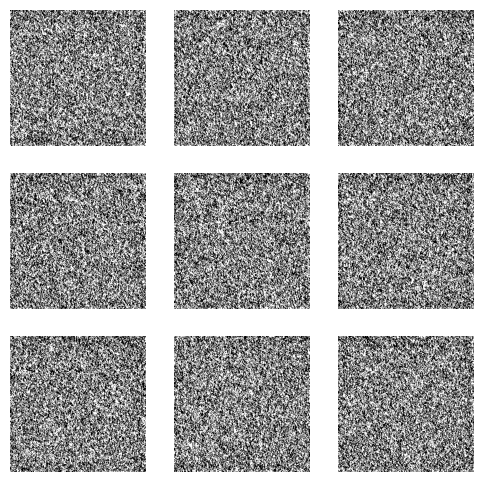

▶️ reverse step t= [15 15 15 15 15 15 15 15 15]
▶️ reverse step t= [14 14 14 14 14 14 14 14 14]
▶️ reverse step t= [13 13 13 13 13 13 13 13 13]
▶️ reverse step t= [12 12 12 12 12 12 12 12 12]
▶️ reverse step t= [11 11 11 11 11 11 11 11 11]
▶️ reverse step t= [10 10 10 10 10 10 10 10 10]
▶️ reverse step t= [9 9 9 9 9 9 9 9 9]
▶️ reverse step t= [8 8 8 8 8 8 8 8 8]
▶️ reverse step t= [7 7 7 7 7 7 7 7 7]
▶️ reverse step t= [6 6 6 6 6 6 6 6 6]
▶️ reverse step t= [5 5 5 5 5 5 5 5 5]
▶️ reverse step t= [4 4 4 4 4 4 4 4 4]
▶️ reverse step t= [3 3 3 3 3 3 3 3 3]
▶️ reverse step t= [2 2 2 2 2 2 2 2 2]
▶️ reverse step t= [1 1 1 1 1 1 1 1 1]
▶️ reverse step t= [0 0 0 0 0 0 0 0 0]


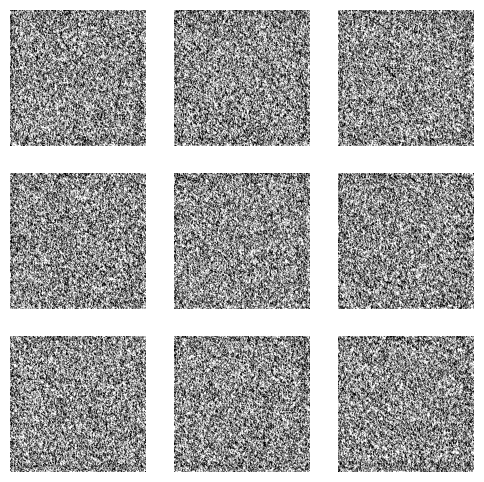

In [11]:
# after loading checkpoint & defining p_sample_cond:
with torch.no_grad():
    debug = sample_images_cond(model, label=0, n_samples=1)
    # you should see call prints or non-zero changes if you add a debug print inside p_sample_cond
print("A tiny patch of your final sample:", debug[0,0,:5,:5])

predict(label=0)
predict(label=1)

In [12]:
def train_step(x0, y0):
    model.train()
    x0, y0 = x0.to(device), y0.to(device)

    # sample timesteps and noise
    t_np         = generate_ts(x0.size(0))
    x_a, x_b, t_t = forward_noise(x0, t_np)
    y_t          = y0

    # forward pass
    pred = model(x_a, t_t, y_t)
    # plain L1
    loss = F.l1_loss(pred, x_b)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()



for epoch in range(1, EPOCHS+1):
    losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        losses.append(train_step(xb, yb))
    print(f"Epoch {epoch} avg loss: {sum(losses)/len(losses):.4f}")
    torch.save(model.state_dict(), f"dm_epoch{epoch}.pt")

Epoch 1/10: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]


Epoch 1 avg loss: 0.2063


Epoch 2/10: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 2 avg loss: 0.0916


Epoch 3/10: 100%|██████████| 163/163 [00:55<00:00,  2.94it/s]


Epoch 3 avg loss: 0.0849


Epoch 4/10: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]


Epoch 4 avg loss: 0.0821


Epoch 5/10: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 5 avg loss: 0.0786


Epoch 6/10: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 6 avg loss: 0.0761


Epoch 7/10: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 7 avg loss: 0.0783


Epoch 8/10: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 8 avg loss: 0.0725


Epoch 9/10: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 9 avg loss: 0.0737


Epoch 10/10: 100%|██████████| 163/163 [00:55<00:00,  2.93it/s]


Epoch 10 avg loss: 0.0718


=== After 5 Epochs: NORMAL ===
▶️ reverse step t= [15 15 15 15 15 15 15 15 15]
▶️ reverse step t= [14 14 14 14 14 14 14 14 14]
▶️ reverse step t= [13 13 13 13 13 13 13 13 13]
▶️ reverse step t= [12 12 12 12 12 12 12 12 12]
▶️ reverse step t= [11 11 11 11 11 11 11 11 11]
▶️ reverse step t= [10 10 10 10 10 10 10 10 10]
▶️ reverse step t= [9 9 9 9 9 9 9 9 9]
▶️ reverse step t= [8 8 8 8 8 8 8 8 8]
▶️ reverse step t= [7 7 7 7 7 7 7 7 7]
▶️ reverse step t= [6 6 6 6 6 6 6 6 6]
▶️ reverse step t= [5 5 5 5 5 5 5 5 5]
▶️ reverse step t= [4 4 4 4 4 4 4 4 4]
▶️ reverse step t= [3 3 3 3 3 3 3 3 3]
▶️ reverse step t= [2 2 2 2 2 2 2 2 2]
▶️ reverse step t= [1 1 1 1 1 1 1 1 1]
▶️ reverse step t= [0 0 0 0 0 0 0 0 0]


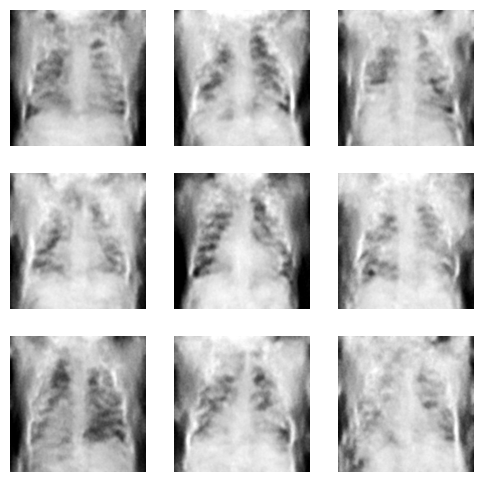

▶️ reverse step t= [15]
▶️ reverse step t= [14]
▶️ reverse step t= [13]
▶️ reverse step t= [12]
▶️ reverse step t= [11]
▶️ reverse step t= [10]
▶️ reverse step t= [9]
▶️ reverse step t= [8]
▶️ reverse step t= [7]
▶️ reverse step t= [6]
▶️ reverse step t= [5]
▶️ reverse step t= [4]
▶️ reverse step t= [3]
▶️ reverse step t= [2]
▶️ reverse step t= [1]
▶️ reverse step t= [0]


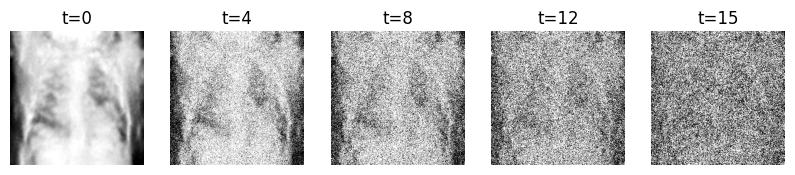

=== After 5 Epochs: PNEUMONIA ===
▶️ reverse step t= [15 15 15 15 15 15 15 15 15]
▶️ reverse step t= [14 14 14 14 14 14 14 14 14]
▶️ reverse step t= [13 13 13 13 13 13 13 13 13]
▶️ reverse step t= [12 12 12 12 12 12 12 12 12]
▶️ reverse step t= [11 11 11 11 11 11 11 11 11]
▶️ reverse step t= [10 10 10 10 10 10 10 10 10]
▶️ reverse step t= [9 9 9 9 9 9 9 9 9]
▶️ reverse step t= [8 8 8 8 8 8 8 8 8]
▶️ reverse step t= [7 7 7 7 7 7 7 7 7]
▶️ reverse step t= [6 6 6 6 6 6 6 6 6]
▶️ reverse step t= [5 5 5 5 5 5 5 5 5]
▶️ reverse step t= [4 4 4 4 4 4 4 4 4]
▶️ reverse step t= [3 3 3 3 3 3 3 3 3]
▶️ reverse step t= [2 2 2 2 2 2 2 2 2]
▶️ reverse step t= [1 1 1 1 1 1 1 1 1]
▶️ reverse step t= [0 0 0 0 0 0 0 0 0]


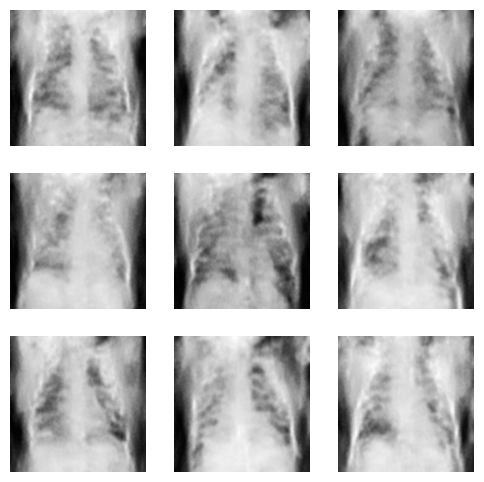

▶️ reverse step t= [15]
▶️ reverse step t= [14]
▶️ reverse step t= [13]
▶️ reverse step t= [12]
▶️ reverse step t= [11]
▶️ reverse step t= [10]
▶️ reverse step t= [9]
▶️ reverse step t= [8]
▶️ reverse step t= [7]
▶️ reverse step t= [6]
▶️ reverse step t= [5]
▶️ reverse step t= [4]
▶️ reverse step t= [3]
▶️ reverse step t= [2]
▶️ reverse step t= [1]
▶️ reverse step t= [0]


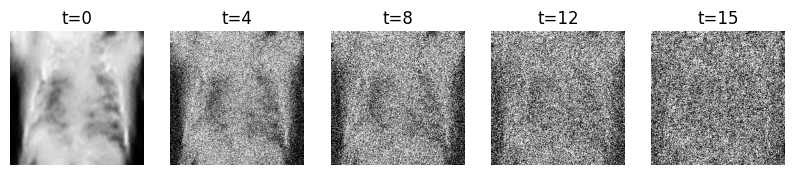

In [14]:
# Reload the most recent checkpoint
state = torch.load("/content/dm_epoch10.pt", map_location=device)
model.load_state_dict(state)
model.eval()

# Sample a grid of “Normal” lungs
print("=== After 5 Epochs: NORMAL ===")
predict(label=0)

# Step‐by‐step denoising for one Normal example
predict_step(label=0)

# And the same for Pneumonia
print("=== After 5 Epochs: PNEUMONIA ===")
predict(label=1)
predict_step(label=1)